In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import cv2
import torchvision
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from local_models import *
from helper_functions import *

from livelossplot import PlotLosses
from pathlib import Path
from torch.utils.data import DataLoader

from dataset import SamDataset

In [7]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

In [42]:
dataroot = Path('C:','\\', 'Users', 'michalro', 'chess_detector', 'chessred') #Change this to match the computer you are working from!
data_path=Path(dataroot, 'annotations.json')
if not data_path.is_file():
    raise(FileNotFoundError(f"File '{data_path}' doesn't exist."))
device = 'cuda' if torch.cuda.is_available() else 'cpu' # set the device according to availability
print(f"device = {device}")

device = cuda


In [43]:
train_dataset = SamDataset(dataroot=dataroot, classifier='pb', split='train', crop = False)
val_dataset = SamDataset(dataroot=dataroot, classifier='pb', split='val', crop = False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #batch size might be too small!
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

torch.Size([8, 256, 256, 3])
tensor([0, 1, 0, 1, 1, 0, 1, 0])


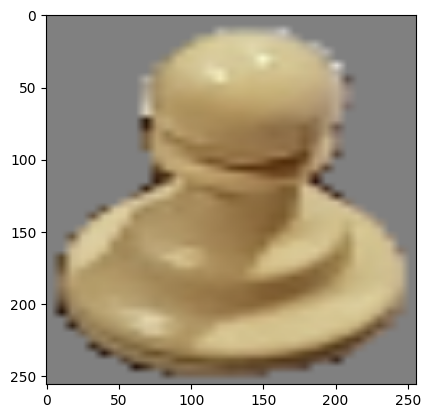

In [28]:
for data, label in train_loader:
    break
# cell to visualize the dataLoader output for crop=false
plt.imshow(data[0])
print(data.shape)
print(label)

## MODEL STARTS HERE

In [44]:
# Load an instance of resnet with pretrained weights.
resnet = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

# Freeze the weights of resnet (because we want to only train the last layer).
for param in resnet.parameters():
    param.requires_grad = False

# Set the number of classes, and modify the last linear layer of the resnet to output that number of values. 
# This layer will have gradients by default.So it will train.
num_classes = 2  # Number of classes in the dataset
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes).to(device)
# Apparently, there is no need to include a softmax layer because the CrossEntropyLoss() takes care of it automatically. 

# Create the transforms to apply to the data. We assume that the data is similar to that of imagenet since we are dealing with natural images. 
# We therefore want to normalize it to have something around mean=1 and std=1. We will see if our assumption that the values are similar to 
# resnet is correct or if we need to find the original mean and variance ourselves in order to normalize properly.
transform = transforms.Compose([
    PermuteChannelIndex(),
    ScalingTransform(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the criterion and optimizer to use in training the model.
lr = 0.01
momentum = 0.9
liveloss = PlotLosses()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=momentum)

In [14]:
# train_dataset = SamDataset(dataroot=dataroot, classifier='pb', split='train', crop = False, transform=transform)
# val_dataset = SamDataset(dataroot=dataroot, classifier='pb', split='val', crop = False, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) #batch size might be too small!
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

TypeError: SamDataset.__init__() got an unexpected keyword argument 'transform'

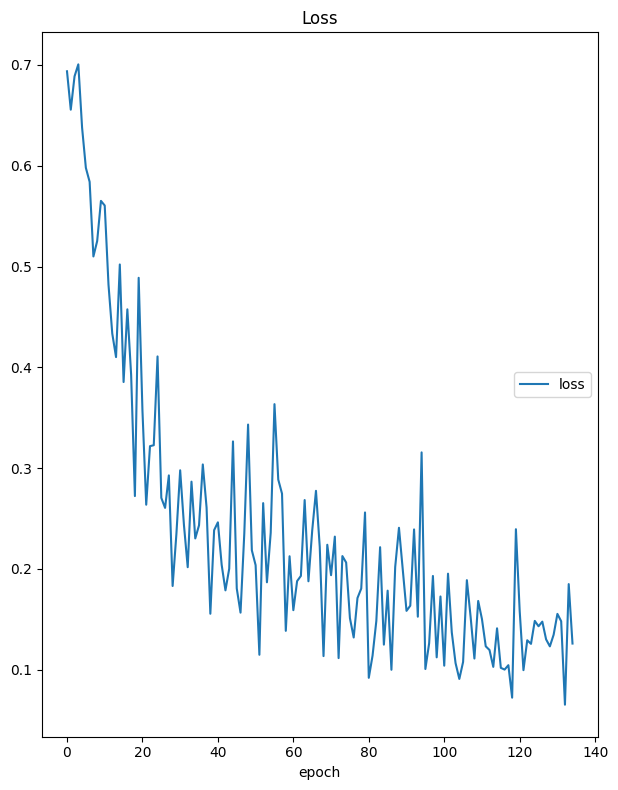

Loss
	loss             	 (min:    0.065, max:    0.701, cur:    0.126)


KeyboardInterrupt: 

In [45]:
# Create the training loop for the model.

# Define the number of epochs
num_epochs = 20 

for epoch in range(num_epochs):
    print(f'epoch number = {epoch}')
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).long()
        data = transform(data).to(device)
        optimizer.zero_grad()
        outputs = resnet(data).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # stuff for plotting the loss.
        
        liveloss.update({"loss": loss.item()})
        liveloss.draw()

In [46]:
print(epoch)


0


In [47]:
# Define the file path for saving the checkpoint
checkpoint_path = Path('C:', '\\', 'Users', 'michalro', 'chess_detector', 'chess_detector', 'PawnBinary', 'model_checkpoint.pth')

# Create a dictionary to store the checkpoint data
checkpoint = {
    'model_state_dict': resnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # Add any additional information you want to save, such as epoch, loss, etc.
}

# Save the checkpoint to the specified file
torch.save(checkpoint, checkpoint_path)


In [48]:
# LOADING CELL. DONT NEED IT EVERY TIME.
# Define the file path for the saved checkpoint
checkpoint_path = Path('C:', '\\', 'Users', 'michalro', 'chess_detector', 'chess_detector', 'PawnBinary', 'model_checkpoint.pth')

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Initialize the model and optimizer
# Assuming you have defined your model architecture and optimizer elsewhere
resnet = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes).to(device)
optimizer = optim.SGD(resnet2.parameters(), lr=lr, momentum=momentum)

# Load the model and optimizer states from the checkpoint
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model and optimizer to the device (e.g., GPU) if you are using one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

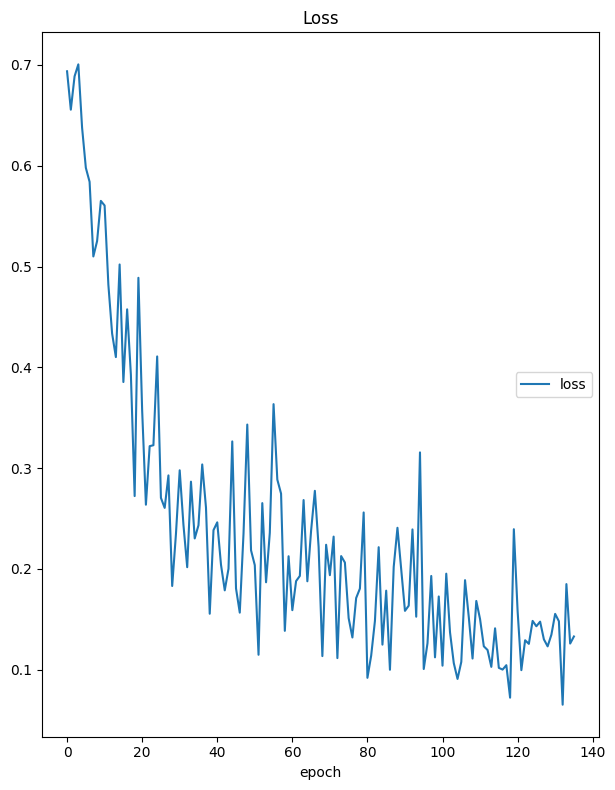

Loss
	loss             	 (min:    0.065, max:    0.701, cur:    0.133)


KeyboardInterrupt: 

In [50]:
# Create the training loop for the model.

# Define the number of epochs
num_epochs = 20 

for epoch in range(num_epochs):
    print(f'epoch number = {epoch}')
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).long()
        data = transform(data).to(device)
        optimizer2.zero_grad()
        outputs = resnet2(data).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # stuff for plotting the loss.
        
        liveloss.update({"loss": loss.item()})
        liveloss.draw()

In [ ]:
# Evaluate the model. 
# Set the model to evaluation mode
resnet.eval()

# Initialize lists to store predictions and ground truth labels
predictions = []
gt_labels = []

# Iterate through the test dataset
for data, labels in val_loader:
    # Move inputs and labels to the device (e.g., GPU) if available
    data, labels = data.to(device), labels.to(device).long()
    data = transform(data).to(device)

    # Forward pass (no need to compute gradients)
    with torch.no_grad():
        outputs = resnet(data)
    
    # Convert outputs to probabilities if needed (e.g., using softmax)
    # probabilities = F.softmax(outputs, dim=1)
    probabilities = nn.functional.softmax(outputs, dim=1)

    # Get predicted classes (e.g., argmax for classification)
    _, predicted = torch.max(outputs, 1)
    
    # Append predictions and ground truth labels
    predictions.extend(predicted.cpu().numpy())
    gt_labels.extend(labels.cpu().numpy())

    # Convert lists to tensors
    predictions_tensor = torch.tensor(predictions)
    gt_labels_tensor = torch.tensor(gt_labels)
    
    # Calculate accuracy (or any other metric)
    accuracy = torch.sum(predictions_tensor == gt_labels_tensor).item() / len(predictions_tensor)
    print(f'Accuracy (for batch): {accuracy:.2f}')

# Convert lists to tensors
predictions = torch.tensor(predictions)
gt_labels = torch.tensor(gt_labels)

# Calculate accuracy (or any other metric)
accuracy = torch.sum(predictions == gt_labels).item() / len(predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy (for batch): 0.94
